# 빈도 분석 및 키워드 추출

## 모듈 호출

In [77]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from collections import defaultdict
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt

# 라이브러리 임포트 및 한글 글꼴 설정
from matplotlib import font_manager, rc
import platform 
font_path = ''
if platform.system() == 'Windows': 
    font_path = 'C:/Windows/Fonts/NGULIM.ttf'
    font_name = font_manager.FontProperties(fname = font_path).get_name()
    rc('font', family = font_name)
elif platform.system() == 'Darwin':
    font_path = '/Users/$USER/Library/Fonts/NanumGothic.ttf'
    rc('font', family = 'AppleGothic')
else: 
    print('Check your OS system')
plt.rcParams['axes.unicode_minus'] = False

## 형태소 분석 된 데이터 호출

In [78]:
df = pd.read_csv('data/ota_morph.csv', encoding='utf-8-sig')
df.dropna(inplace = True)
df.reset_index(drop = True, inplace=True)

In [79]:
df.head()

,name,review,rate,hanspell_review,md_review_eomi_t,md_review_eomi_f
0,월인당[한국관광 품질인증/Korea Quality],"지난 주말, 부모님과 함께 널찍한 노마루가 있는 산노을 방에서 묵었어요. 꽃피는 봄...",5.00,"지난 주말, 부모님과 함께 널찍한 노마루가 있는 산노을 방에서 묵었어요. 꽃피는 봄...",지나다 주말 부모 함께 널찍 노마 루가 산 노을 방 묵다 꽃피다 봄 오다 떨어지다 ...,지나 주말 부모 함께 널찍 노마 루가 산 노을 방 묵 꽃피 봄 오 떨어지 좀 쌀쌀 ...
1,와담정[한국관광 품질인증/Korea Quality],월정교와도 가깝고 방도 넘 깨끗했습니다. 사장님도 너무 친절하시고 좋았어요. 특히 ...,5.00,월정교와도 가깝고 방도 넘 깨끗했습니다. 사장님도 너무 친절하시고 좋았어요. 특히 ...,월정 교 가깝다 방도 너무 깨끗 사장 너무 친절 좋다 특히 뚜벅 체크아웃 하다 때 ...,월정 교 가깝 방도 너무 깨끗 사장 너무 친절 좋 특히 뚜벅 체크아웃 하 때 걸어가...
2,와담정[한국관광 품질인증/Korea Quality],목조 한옥이다보니 벌레가 너무 많았어요. 톡톡이라고 깨알보다 작은 벌레들이 이불에도...,2.65,목조 한옥이다보니 벌레가 너무 많았어요. 톡톡이라고 깨알보다 작은 벌레들이 이불에도...,목조 한옥 벌레 너무 많다 톡톡이 깨알 작다 벌레 이불 기어 다니다 친구 다 불편 ...,목조 한옥 벌레 너무 많 톡톡이 깨알 작 벌레 이불 기어 다니 친구 다 불편 하 밖...
3,비센트호텔[한국관광 품질인증/Korea Quality],"아주 늦은시간 도착했는데 프론트 친절하시고, 객실정비도 잘 되어있고 수건도 넉넉해...",5.00,"아주 늦은시간 도착했는데 프론트 친절하시고, 객실정비도 잘 되어있고 수건도 넉넉해...",아주 늦다 시간 도착 프론트 친절 객실 정비 잘 되다 수건 넉넉 머무다 동 안 편리...,아주 늦 시간 도착 프론트 친절 객실 정비 잘 되 수건 넉넉 머무 동 안 편리 좋 ...
4,비센트호텔[한국관광 품질인증/Korea Quality],가격대비 만족합니다호텔도 깨끗한 편이에요,5.00,가격대비 만족합니다호텔도 깨끗한 편이에요,가격 대비 만족 호텔 깨끗 편,가격 대비 만족 호텔 깨끗 편


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114259 entries, 0 to 114258
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              114259 non-null  object 
 1   review            114259 non-null  object 
 2   rate              114259 non-null  float64
 3   hanspell_review   114259 non-null  object 
 4   md_review_eomi_t  114259 non-null  object 
 5   md_review_eomi_f  114259 non-null  object 
dtypes: float64(1), object(5)
memory usage: 5.2+ MB


## 긍정/부정 데이터 분리 및 라벨링
- 긍정: rate == 5
- 부정: rate < 2.5

In [81]:
df_pos = df[df['rate'] == 5]
df_pos['pn'] = 1
df_neg = df[df['rate'] < 2.5]
df_neg['pn'] = 0

<ipython-input-81-b2f2e6d4f83e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos['pn'] = 1
<ipython-input-81-b2f2e6d4f83e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['pn'] = 0


## 형태소 분석된 리뷰를 하나의 리스트로 all_rev

In [82]:
all_rev_pos = df_pos['md_review_eomi_t'].to_list()
all_rev_pos_list = []
for i in all_rev_pos:
    temp_list = i.split(' ')
    all_rev_pos_list.append(temp_list)

all_rev_neg = df_neg['md_review_eomi_t'].to_list()
all_rev_neg_list = []
for i in all_rev_neg:
    temp_list = i.split(' ')
    all_rev_neg_list.append(temp_list)

all_rev = df['md_review_eomi_t'].to_list()
all_rev_list = []
for i in all_rev:
    temp_list = i.split(' ')
    all_rev_list.append(temp_list)

## 불용어 제거 함수

In [83]:
#불용어 제거 함수
stw = pd.read_csv('data/stopword_dict.csv',encoding = 'utf-8-sig') #불용어사전 불러오기
stw = stw['stopWords'].to_list()
def cleaning(text):
    clean_ = text.split(' ')
    clean_ = [x for x in clean_ if x not in stw]
    return clean_

## 빈도 분석

### counter를 이용하여 빈도 분석
    counter로 빈도 분석

#### 형태소 분석된 모든 리뷰를 단어 단위로 분리 words

In [84]:
pos_word = ''
for text in df_pos['md_review_eomi_t']:
    pos_word = pos_word + ' ' +text
pos_words = pos_word.split()    

neg_word = ''
for text in df_neg['md_review_eomi_t']:
    neg_word = neg_word + ' ' +text
neg_words = neg_word.split()  

In [85]:
clean_pos_words = [x for x in pos_words if x not in stw] #불용어 제거
clean_neg_words = [x for x in neg_words if x not in stw] 

In [86]:
pos_counts = Counter(clean_pos_words) #하나의 리스트에 들어있는 단어들의 수 카운트
pos_sorted_keys = sorted(pos_counts, key=pos_counts.get, reverse=True) #빈도를 내림차순으로 정렬
pos_sorted_values = sorted(pos_counts.values(), reverse=True)
#빈도를 비율로 변경
pos_sum_values = sum(pos_sorted_values) #빈도 총합
pos_sorted_ratio = [round((value / pos_sum_values)*100, 2) for value in pos_sorted_values] #비율로 변환

neg_counts = Counter(clean_neg_words) #하나의 리스트에 들어있는 단어들의 수 카운트
neg_sorted_keys = sorted(neg_counts, key=neg_counts.get, reverse=True) #빈도를 내림차순으로 정렬
neg_sorted_values = sorted(neg_counts.values(), reverse=True)
#빈도를 비율로 변경
neg_sum_values = sum(neg_sorted_values) #빈도 총합
neg_sorted_ratio = [round((value / neg_sum_values)*100, 2) for value in neg_sorted_values] #비율로 변환

### 시각화

#### 막대그래프

=== 긍정 단어비율 ===


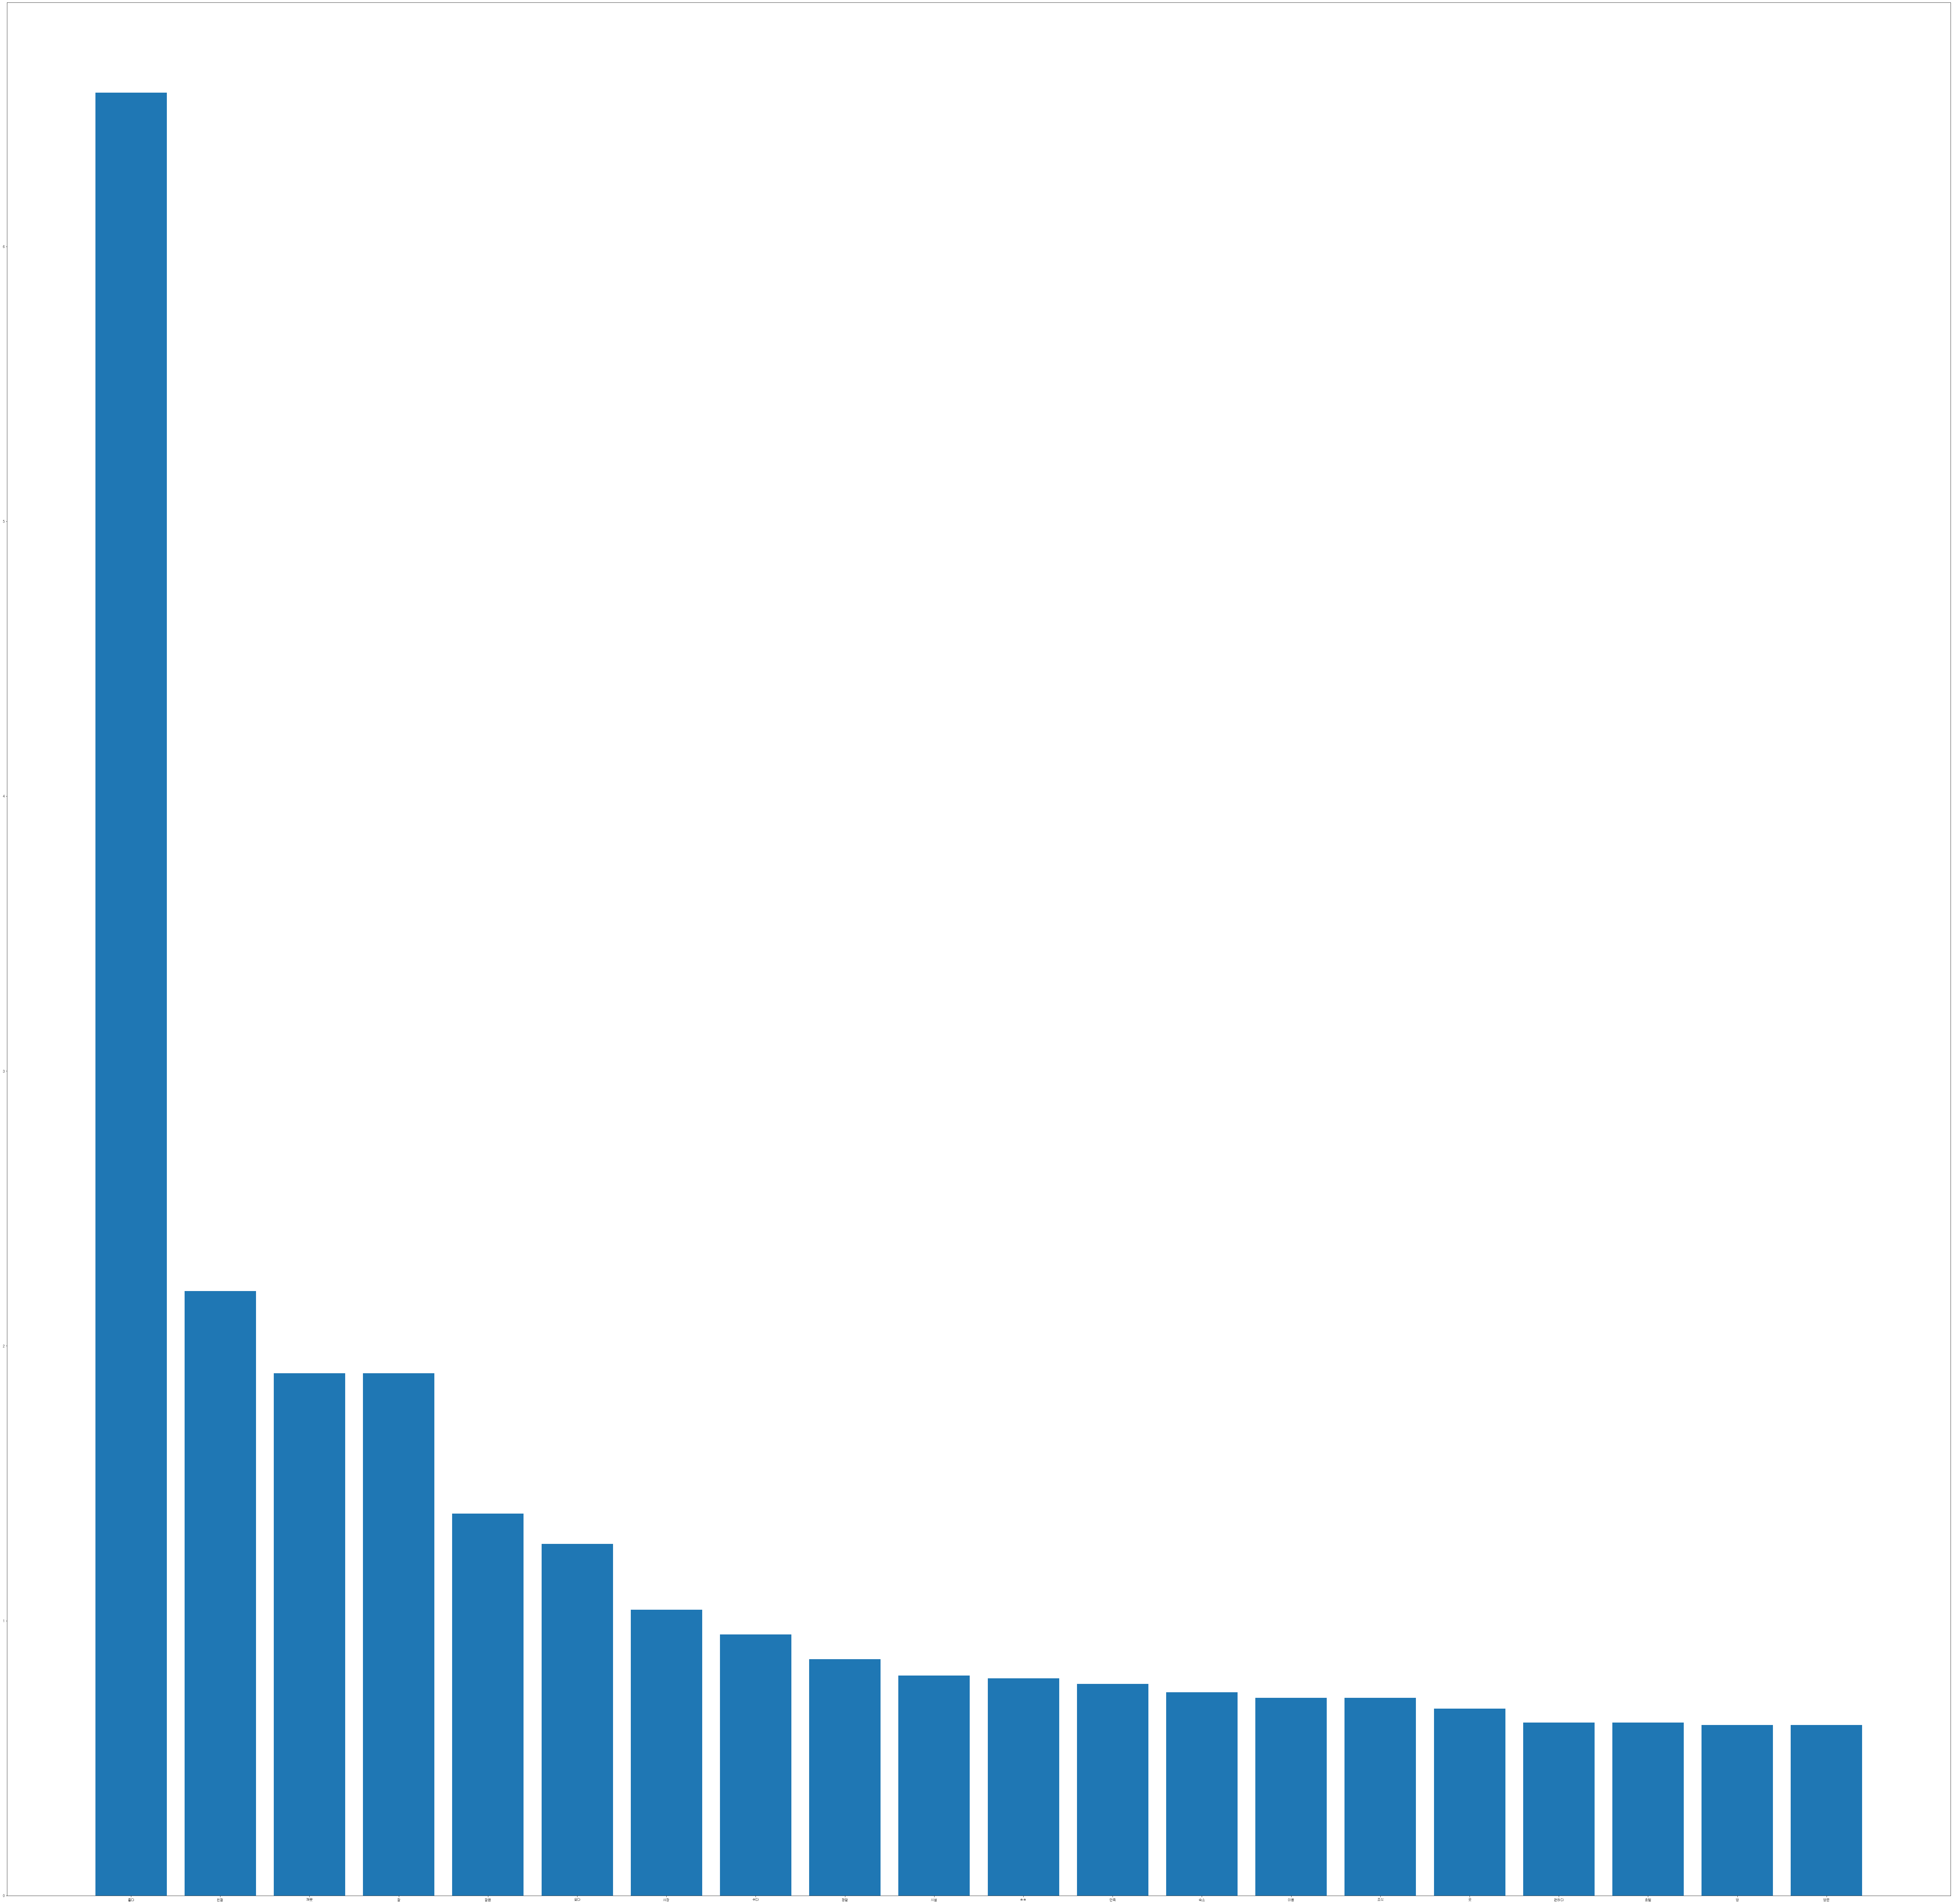

In [87]:
print('=== 긍정 단어비율 ===')
plt.bar(range(20), pos_sorted_ratio[:20])
plt.rcParams["figure.figsize"] = (10, 10)
plt.xticks(range(20), pos_sorted_keys[:20])
plt.show()


=== 부정 단어비율 ===


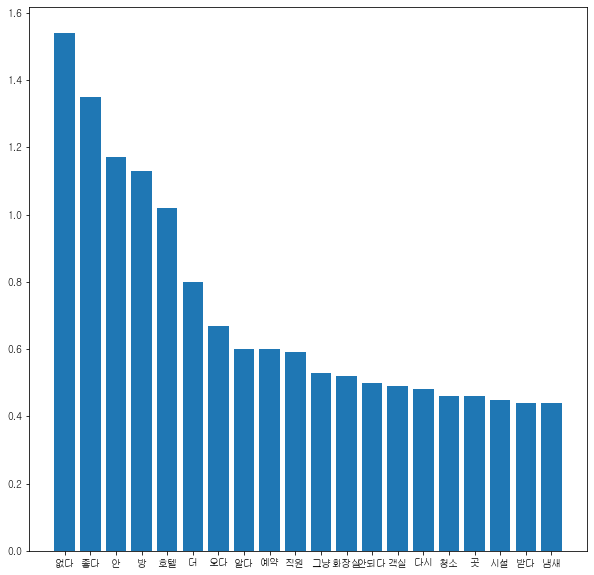

In [88]:
print('=== 부정 단어비율 ===')
plt.bar(range(20), neg_sorted_ratio[:20])
plt.rcParams["figure.figsize"] = (10, 10)
plt.xticks(range(20), neg_sorted_keys[:20])
plt.show()

#### 워드클라우드

In [89]:
pos_word_count_dict = dict(zip(pos_sorted_keys, pos_sorted_ratio)) #워드 클라우드에 넣기 위해서 딕셔너리 형태로 변환
neg_word_count_dict = dict(zip(neg_sorted_keys, neg_sorted_ratio)) 

<function matplotlib.pyplot.show(close=None, block=None)>

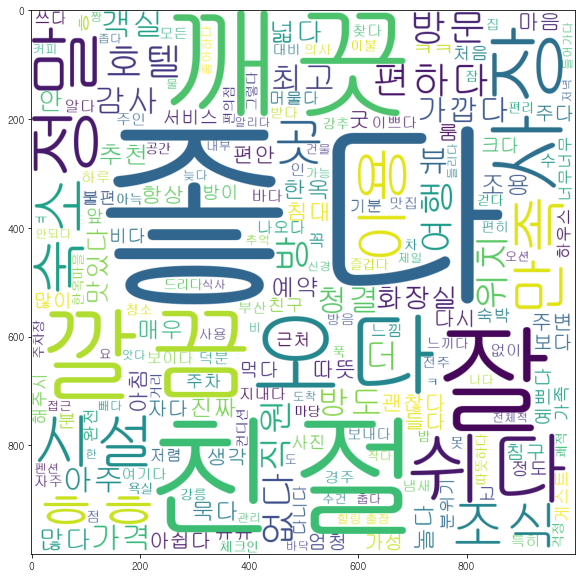

In [90]:
wc = WordCloud(
    font_path = 'C:/Windows/Fonts/NGULIM.ttf',
    background_color='white',
    width=1000,
    height=1000
)

# max_words의 기본값이 200이기 때문에 200개까지 나타남.
wc_img = wc.generate_from_frequencies(pos_word_count_dict)
plt.imshow(wc_img)
plt.rcParams["figure.figsize"] = (100, 100)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

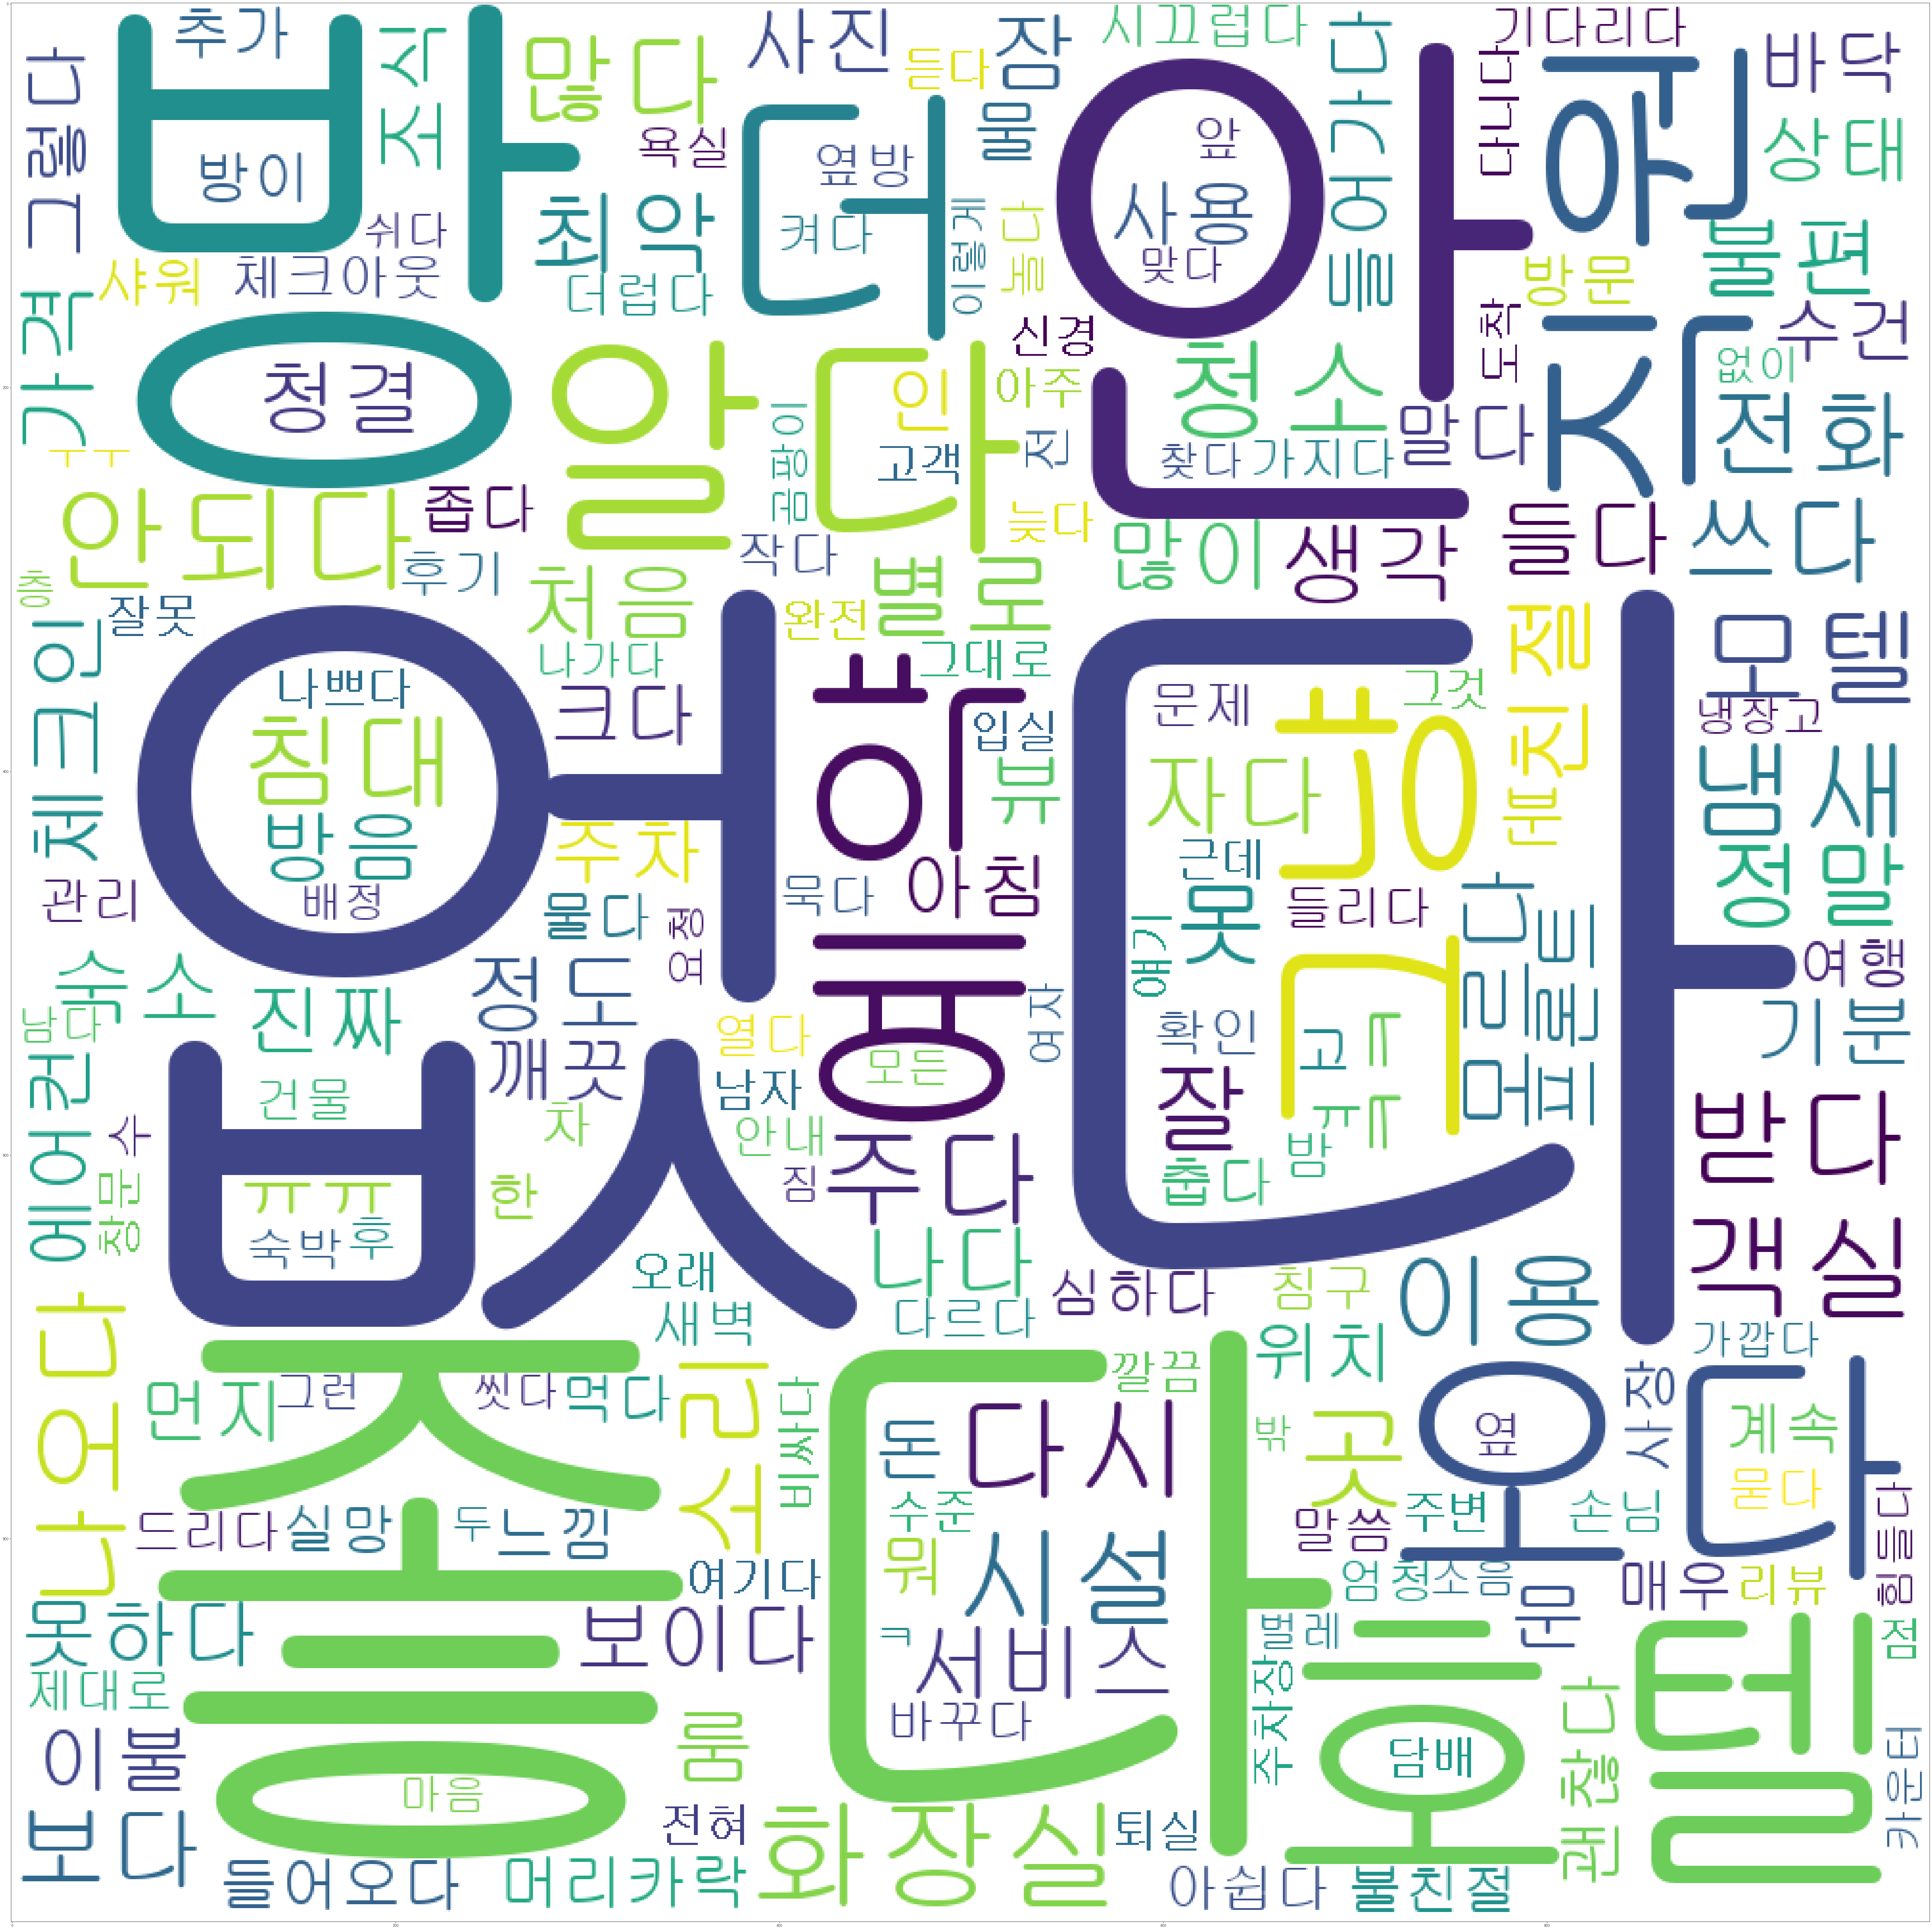

In [91]:
#부정단어
wc = WordCloud(
    font_path = 'C:/Windows/Fonts/NGULIM.ttf',
    background_color='white',
    width=1000,
    height=1000
)

# max_words의 기본값이 200이기 때문에 200개까지 나타남.
wc_img = wc.generate_from_frequencies(neg_word_count_dict)
plt.imshow(wc_img)
plt.rcParams["figure.figsize"] = (100, 100)
plt.show

### CounetVectorizer()를 이용해서 전체 단어 빈도분석 
    

In [92]:
c_vect = CountVectorizer(max_features = 200, max_df=0.95, min_df=0,tokenizer=cleaning) #한글자 단어가 사라짐
bow_vect = c_vect.fit_transform(all_rev)
word_list = c_vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)

In [93]:
word_count_dict = dict(zip(word_list, count_list))

#### 시각화

##### 막대그래프

In [94]:
sorted_keys = sorted(word_count_dict, key=word_count_dict.get, reverse=True) #빈도를 내림차순으로 정렬
sorted_values = sorted(word_count_dict.values(), reverse=True)
#빈도를 비율로 변경
sum_values = sum(sorted_values) #빈도 총합
sorted_ratio = [round((value / sum_values)*100, 2) for value in sorted_values] #비율로 변환

=== 단어비율 ===


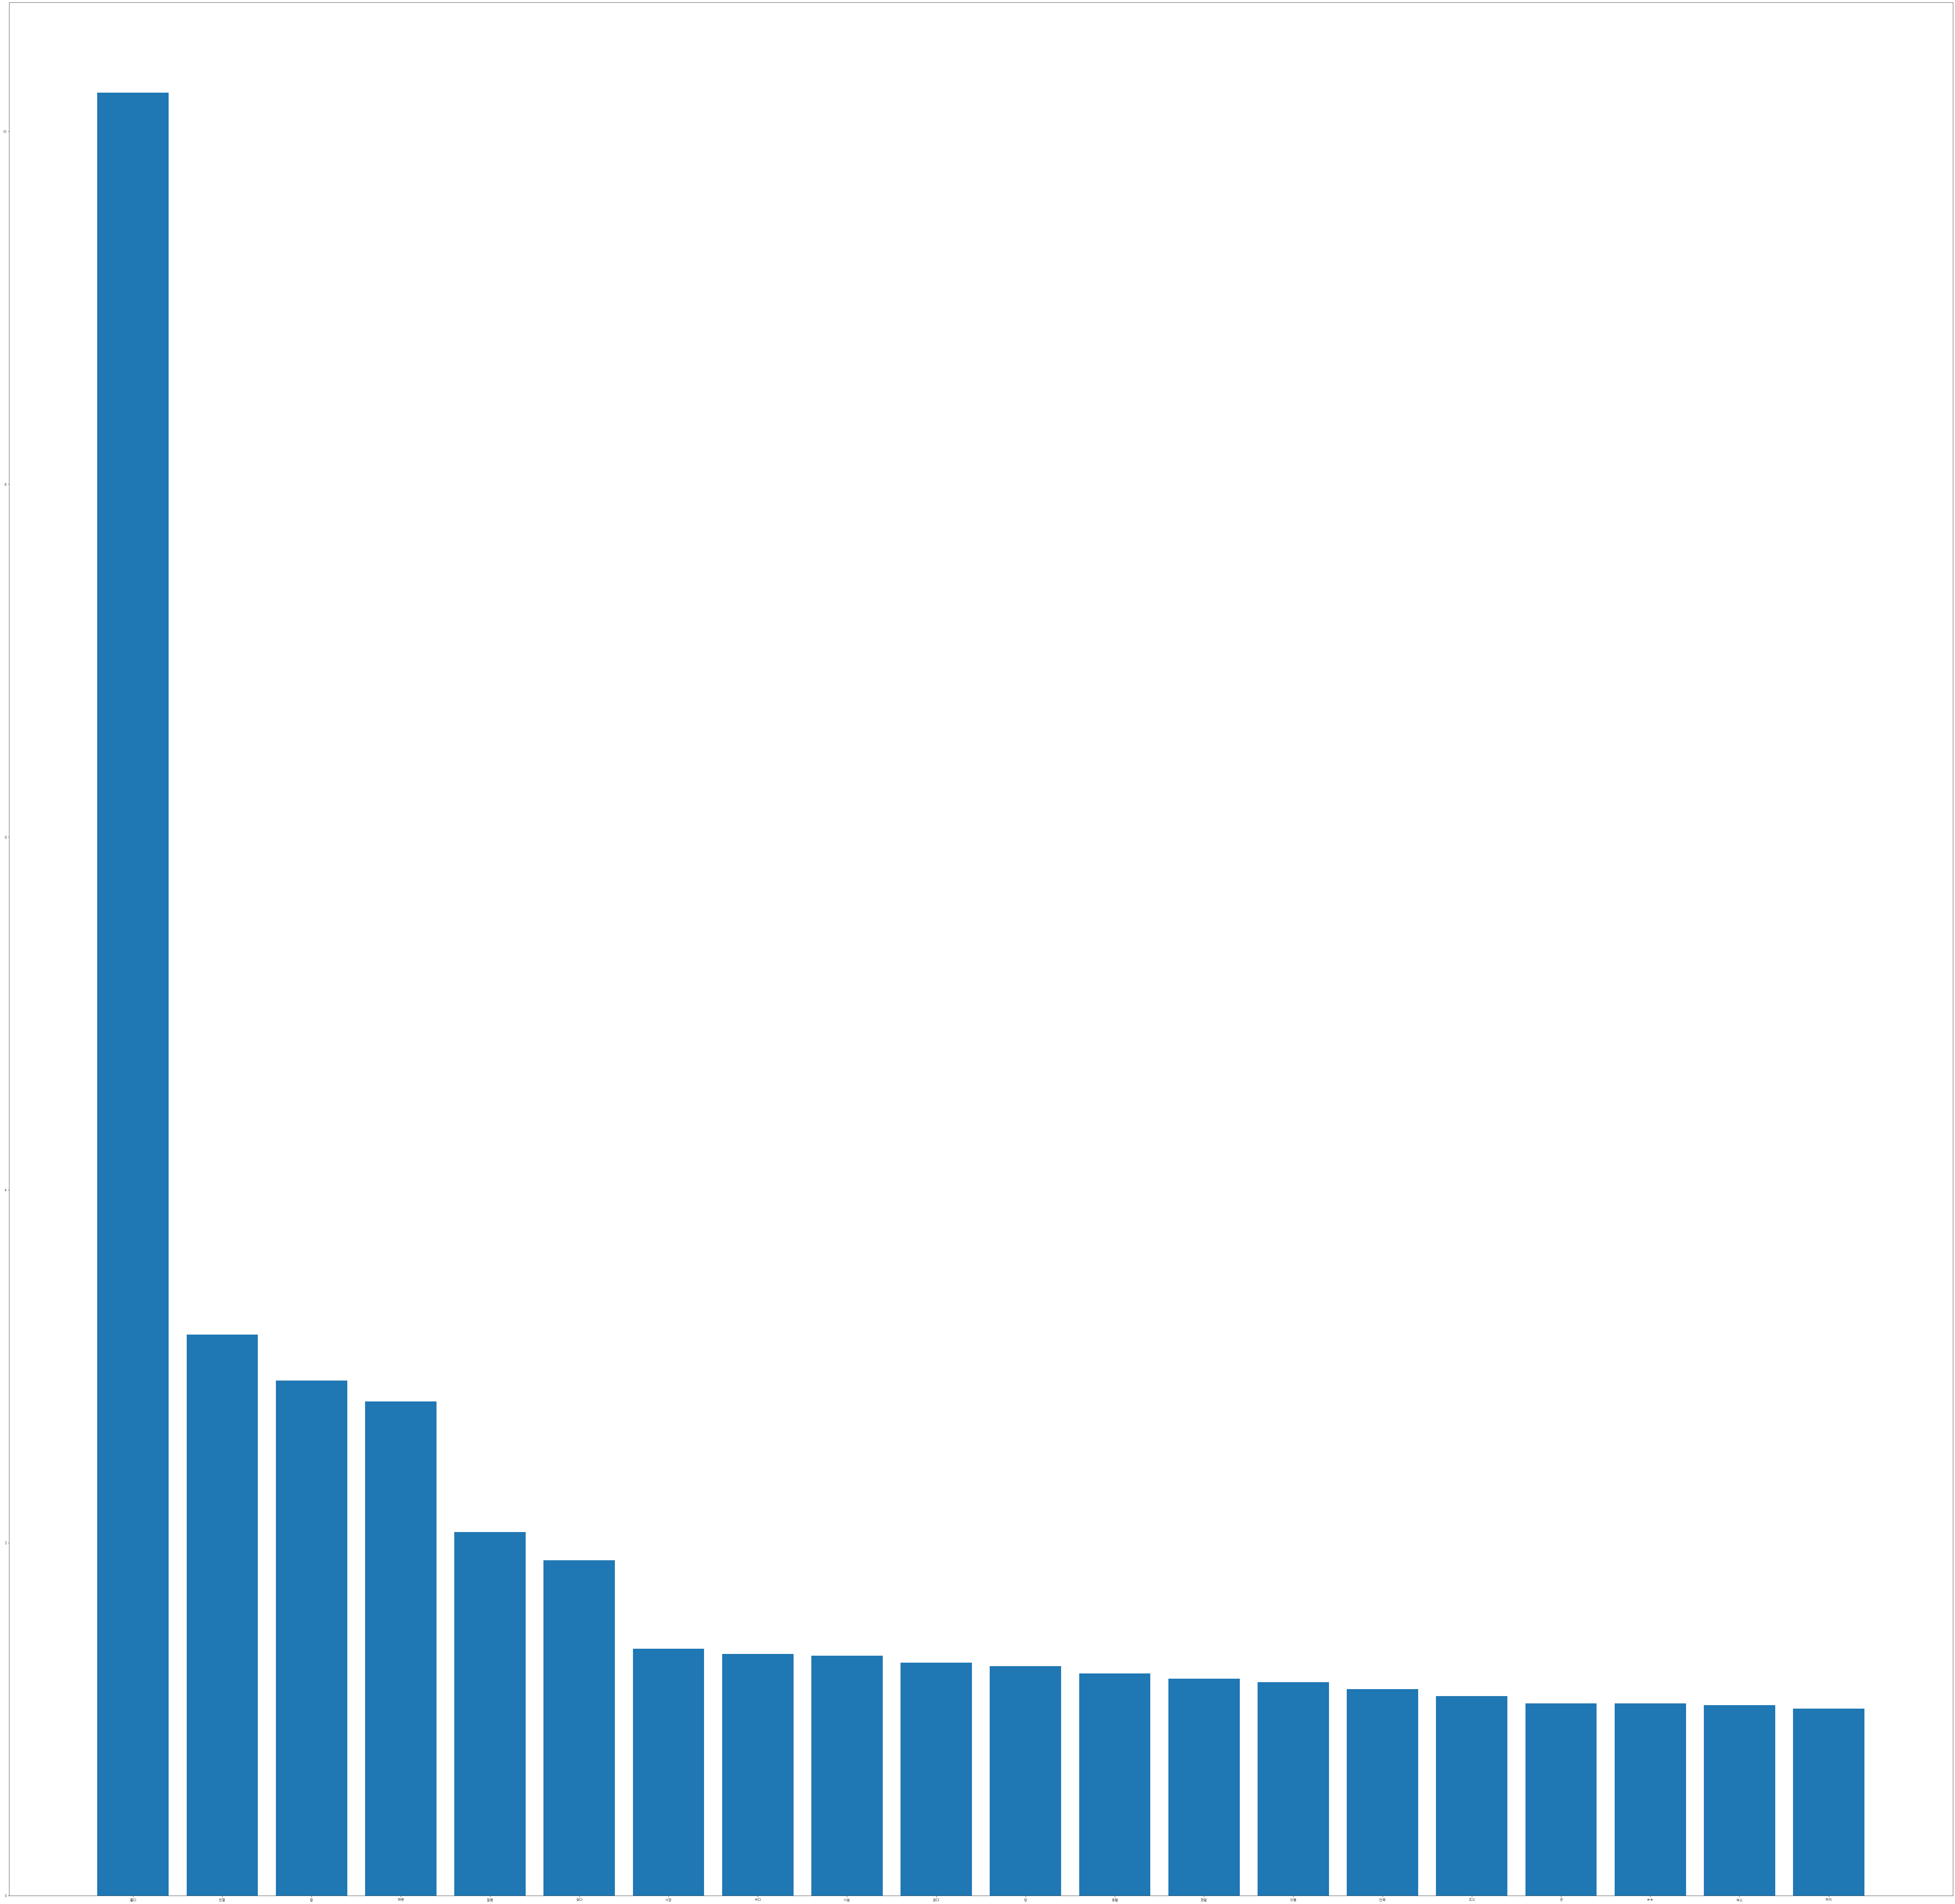

In [95]:
print('=== 단어비율 ===')
plt.bar(range(20), sorted_ratio[:20])
plt.rcParams["figure.figsize"] = (10, 10)
plt.xticks(range(20), sorted_keys[:20])
plt.show()


##### 워드클라우드

<function matplotlib.pyplot.show(close=None, block=None)>

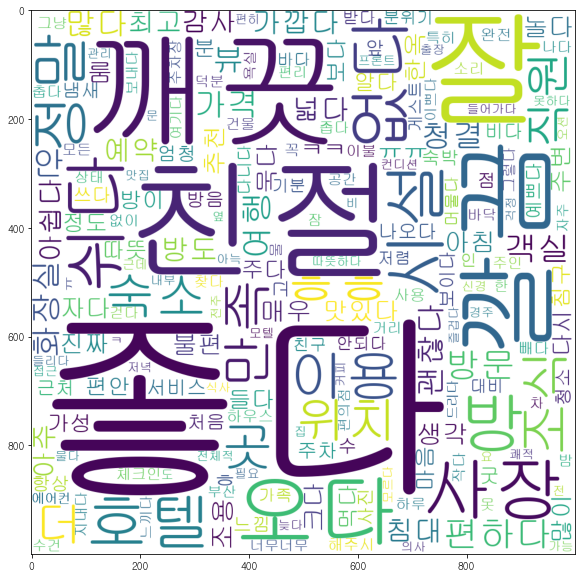

In [96]:
wc = WordCloud(
    font_path = 'C:/Windows/Fonts/NGULIM.ttf',
    background_color='white',
    width=1000,
    height=1000
)

# max_words의 기본값이 200이기 때문에 200개까지 나타남.
wc_img = wc.generate_from_frequencies(word_count_dict)
plt.imshow(wc_img)
plt.rcParams["figure.figsize"] = (100, 100)
plt.show

## tf-idf vecorize를 이용한 logstic Regression

#### 분리한 긍부정데이터를 합치기
- 긍정: 5점 = 확실한 긍정
- 부정: 2.5점 미만 = 확실한 부정


In [97]:
df_pn = pd.concat([df_pos,df_neg])
df_pn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84128 entries, 0 to 114248
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              84128 non-null  object 
 1   review            84128 non-null  object 
 2   rate              84128 non-null  float64
 3   hanspell_review   84128 non-null  object 
 4   md_review_eomi_t  84128 non-null  object 
 5   md_review_eomi_f  84128 non-null  object 
 6   pn                84128 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 5.1+ MB


### tf-idf vectorization

In [98]:
#max_features를 설정하기 위해 사용된 형태소의 수 파악
all_word = ''
for text in df_pn['md_review_eomi_t']:
    all_word = all_word + ' ' +text
all_words = all_word.split()   
all_wordsv= pd.Series(all_words).drop_duplicates(keep='first')
len(all_words)

1315998

In [99]:
tf_idf_vectorizer = TfidfVectorizer(max_features = 100000, max_df=0.95, min_df=0)
sp_matrix = tf_idf_vectorizer.fit_transform(df_pn['md_review_eomi_t'].to_list())

In [100]:
tfidf_dict = tf_idf_vectorizer.get_feature_names()

### train test split

In [101]:
x = sp_matrix
y = df_pn['pn']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state=123)


In [102]:
# fit in training set
lr = LogisticRegression(class_weight='balanced',random_state = 123)
lr.fit(x_train, y_train)

# predict in test set
y_pred = lr.predict(x_test)

C:\Users\harry\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [103]:
print('accuracy: %.2f' % accuracy_score(y_test, y_pred))
print('precision: %.2f' % precision_score(y_test, y_pred))
print('recall: %.2f' % recall_score(y_test, y_pred))
print('F1: %.2f' % f1_score(y_test, y_pred))

accuracy: 0.94
precision: 0.99
recall: 0.94
F1: 0.97


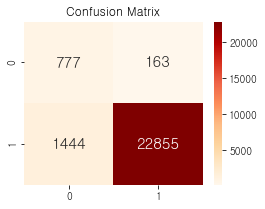

In [104]:
# confusion matrix
confu = confusion_matrix(y_true = y_test, y_pred = y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

<BarContainer object of 17573 artists>

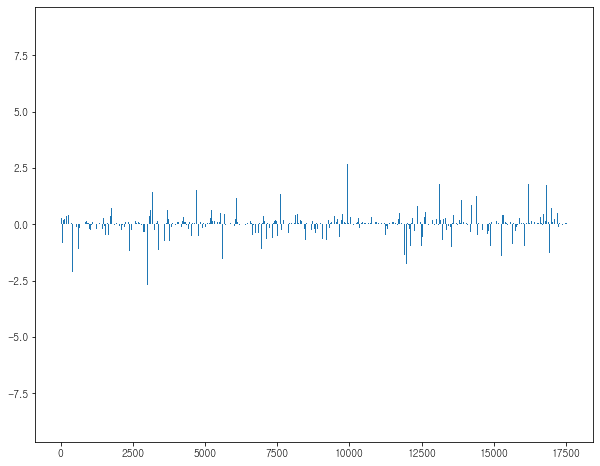

In [105]:
plt.figure(figsize=(10, 8))
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [106]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = True)[-5:])
# enumerate: 인덱스 번호와 컬렉션의 원소를 tuple형태로 반환함

[(8.764651865192214, 2219), (7.669705418524998, 4869), (6.428674755140647, 353), (5.442816606550804, 4286), (5.208519581830591, 16048)]
[(-5.019583222916912, 1715), (-6.339556270414251, 9339), (-6.649748411612792, 6556), (-7.160290603214644, 7068), (-8.775746239072046, 14934)]


In [107]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = False)
coef_pos_index

[(8.764651865192214, 2219),
 (7.669705418524998, 4869),
 (6.428674755140647, 353),
 (5.442816606550804, 4286),
 (5.208519581830591, 16048),
 (4.867530521424957, 637),
 (4.577938826637679, 16858),
 (4.083062148348478, 7532),
 (4.042326631430658, 17563),
 (3.9615384644919653, 3130),
 (3.7978858471159693, 15140),
 (3.7334010998960427, 11130),
 (3.729637391315171, 6135),
 (3.6510699698980638, 14904),
 (3.6390580907539167, 2774),
 (3.612166034125303, 4941),
 (3.560263763630287, 9557),
 (3.5407010224789084, 10798),
 (3.4798823813542983, 13616),
 (3.4218656498782294, 14034),
 (3.4107689199986293, 13183),
 (3.3474341525081694, 7350),
 (3.330865465431885, 10218),
 (3.310794944172961, 13987),
 (3.288046875677611, 2793),
 (3.278914844211895, 16059),
 (3.187403746597476, 13730),
 (3.1040827279501775, 345),
 (3.0936273437083757, 10473),
 (3.0774898717732797, 12114),
 (3.0107547782387383, 16045),
 (2.9803230123134177, 5271),
 (2.9303835524932413, 13353),
 (2.930009805505566, 16058),
 (2.818556115545

In [108]:
invert_index_vectorizer = {v: k for k, v in tf_idf_vectorizer.vocabulary_.items()}
invert_index_vectorizer

{14025: '지나다',
 13771: '주말',
 6847: '부모',
 16725: '함께',
 2791: '널찍',
 2858: '노마',
 4610: '루가',
 2876: '노을',
 5523: '묵다',
 2322: '꽃피다',
 10857: '오다',
 4374: '떨어지다',
 9452: '쌀쌀',
 2550: '날씨',
 4431: '뜨끈뜨끈',
 16434: '하다',
 1481: '구들장',
 9582: '아랫목',
 3624: '덕분',
 13353: '정말',
 4286: '따뜻',
 12599: '자다',
 10576: '여행',
 16352: '피로도',
 16211: '풀다',
 9035: '시골집',
 13323: '정겨움',
 3021: '느끼다',
 8751: '숙소',
 6111: '밤하늘',
 6551: '별도',
 11136: '완전',
 6674: '보이다',
 3020: '느긋',
 12646: '자연',
 16647: '한옥',
 14803: '체험',
 11565: '원하다',
 453: '강추',
 11589: '월정',
 52: '가깝다',
 6135: '방도',
 2772: '너무',
 2239: '깨끗',
 7532: '사장',
 15140: '친절',
 13729: '좋다',
 15845: '특히',
 4405: '뚜벅',
 14799: '체크아웃',
 704: '걸어가다',
 7847: '생각',
 637: '걱정',
 15613: '태우다',
 353: '감사',
 3130: '다만',
 6188: '방음',
 11130: '완벽',
 4006: '되다',
 13620: '조용히',
 10114: '얘기',
 10780: '옆방',
 8355: '소리',
 4194: '들리다',
 31: 'ㅎㅎ',
 6423: '벌레',
 10350: '없다',
 10403: '에어컨',
 6678: '보일러',
 5271: '모두',
 12716: '작동',
 15392: '쾌적',
 12566: '있다',
 13

In [109]:
for coef in coef_pos_index[:50]:
    print(invert_index_vectorizer[coef[1]], coef[0])


깔끔 8.764651865192214
만족 7.669705418524998
감사 6.428674755140647
따뜻 5.442816606550804
편안 5.208519581830591
걱정 4.867530521424957
해주시 4.577938826637679
사장 4.083062148348478
힐링 4.042326631430658
다만 3.9615384644919653
친절 3.7978858471159693
완벽 3.7334010998960427
방도 3.729637391315171
최고 3.6510699698980638
너무너무 3.6390580907539167
맛있다 3.612166034125303
아늑 3.560263763630287
예쁘다 3.5407010224789084
조용 3.4798823813542983
지내다 3.4218656498782294
전주 3.4107689199986293
빼다 3.3474341525081694
어용 3.330865465431885
즐겁다 3.310794944172961
넓다 3.288046875677611
편히 3.278914844211895
좋아하다 3.187403746597476
감동 3.1040827279501775
여기다 3.0936273437083757
이쁘다 3.0774898717732797
편리 3.0107547782387383
모두 2.9803230123134177
정말 2.9303835524932413
편하다 2.930009805505566
훌륭 2.818556115545491
경주 2.813700645067201
자주 2.813462708338065
강추 2.811034626287745
마음 2.8074369886614785
살짝 2.7984269466370644
가장 2.7417419954859787
친구 2.724411348188341
재미있다 2.706303739657438
놀다 2.7050519837845877
앗다 2.670146850639838
넉넉 2.6701323064068117

In [110]:
for coef in coef_neg_index[:50]:
    print(invert_index_vectorizer[coef[1]], coef[0])

최악 -8.775746239072046
불친절 -7.160290603214644
별로 -6.649748411612792
실망 -6.339556270414251
그냥 -5.019583222916912
더럽다 -4.86790707609458
모텔 -4.801144711947183
먼지 -4.710954559540586
아깝다 -4.587263985491698
노후 -4.488853523719316
전화 -4.259189891692291
곰팡이 -4.245775686655344
심하다 -4.1553687353933375
작고 -4.081664310616059
시끄럽다 -4.057597659178847
태도 -3.990787521456683
특이하다 -3.955892855841347
알다 -3.883880126083881
비추다 -3.8158477767758923
쓰레기 -3.800752653438508
떨어지다 -3.7661117732078613
춥다 -3.756184645344191
엉망 -3.735603495062236
그냥저냥 -3.734615319304554
지저분 -3.7235167235936264
모르다 -3.682591029402835
확인 -3.672712469893052
비싸다 -3.608342490369971
황당 -3.5521440754438127
옮기다 -3.4840829465587424
못하다 -3.444379491492624
그닥 -3.3880473407584772
낡다 -3.3750337045213623
그럭저럭 -3.3708630134899282
이것 -3.3442663279345197
그저 -3.341623129697436
무슨 -3.3322546673986104
밤새 -3.3109118940747413
냄새나다 -3.266598212911003
은전 -3.218708542820701
패스 -3.212789461852741
그나마 -3.1737611082956514
차라리 -3.167379689353237
옆방 -3.1387582031

## 오버샘플링 후 다시 분석

In [111]:
x_resampled, y_resampled = SMOTE(random_state=0).fit_resample(x_train, y_train)

In [112]:
x_resampled.shape, y_resampled.shape

((113502, 17573), (113502,))

In [113]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(x_resampled, y_resampled, test_size = 0.3, random_state=123)

In [114]:
# fit in training set
lr2 = LogisticRegression(class_weight='balanced',random_state = 123)
lr2.fit(x_train2, y_train2)

# predict in test set
y_pred2 = lr2.predict(x_test2)

print('accuracy: %.2f' % accuracy_score(y_test2, y_pred2))
print('precision: %.2f' % precision_score(y_test2, y_pred2))
print('recall: %.2f' % recall_score(y_test2, y_pred2))
print('F1: %.2f' % f1_score(y_test2, y_pred2))

accuracy: 0.94
precision: 0.96
recall: 0.91
F1: 0.94


C:\Users\harry\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


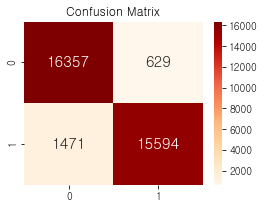

In [115]:
# confusion matrix
confu = confusion_matrix(y_true = y_test2, y_pred = y_pred2)

plt.figure(figsize=(4, 3))
sns.heatmap(confu, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()

<BarContainer object of 17573 artists>

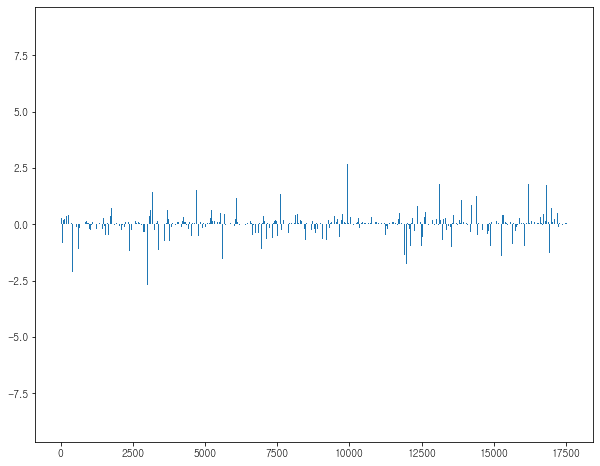

In [116]:
plt.figure(figsize=(10, 8))
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

In [117]:
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = True)
coef_neg_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse = False)

In [118]:
#부정 긍정 높은 형태소 뽑기
md_pos_word = []
md_neg_word = []
md_pos_coef = []
md_neg_coef = []

for coef in coef_pos_index[:1000]:
    md_pos_word.append(invert_index_vectorizer[coef[1]])
    md_pos_coef.append(coef[0])
    
for coef in coef_neg_index[:1000]:
    md_neg_word.append(invert_index_vectorizer[coef[1]])
    md_neg_coef.append(coef[0])
    
for_dict = pd.DataFrame()
for_dict['긍정어'] = md_pos_word
for_dict['긍정회귀계수'] = md_pos_coef
for_dict['부정어'] = md_neg_word
for_dict['부정회귀계수'] = md_neg_coef
for_dict.to_csv('data/tf-idf_감성어분류_어미.csv',encoding='utf-8-sig',index=None)